In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
import joblib
import json
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Loading model metrics

try:
    baseline_metrics = pd.read_csv('C:/Users/battu/Documents/SmartEnergyML/data/processed/baseline_model_metrics.csv')
    lstm_metrics = pd.read_csv('C:/Users/battu/Documents/SmartEnergyML/data/processed/lstm_model_metrics.csv')
    print(" Baseline (Linear Regression) metrics loaded")
    print(" LSTM metrics loaded")
except FileNotFoundError as e:
    print(f" Error: {e}")
    print("Please run Module 4 and Module 5 first")
    exit()

# Extract test metrics
baseline_test = baseline_metrics[baseline_metrics['Dataset'] == 'Test'].iloc[0]
lstm_test = lstm_metrics[lstm_metrics['Dataset'] == 'Test'].iloc[0]

print("\n Test Set Metrics Summary:")
print(f"\n{'Metric':<15} {'Linear Regression':>20} {'LSTM':>20}")
for metric in ['MAE', 'RMSE', 'R² Score', 'MAPE (%)']:
    print(f"{metric:<15} {baseline_test[metric]:>20.4f} {lstm_test[metric]:>20.4f}")

 Baseline (Linear Regression) metrics loaded
 LSTM metrics loaded

 Test Set Metrics Summary:

Metric             Linear Regression                 LSTM
MAE                           0.0030               0.3097
RMSE                          0.0103               0.4526
R² Score                      0.9998               0.5745
MAPE (%)                      0.6446              39.1477


In [4]:
# Detailed Model Comparison

# Compare across all datasets
print("\n FULL COMPARISON TABLE:")

comparison = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'R² Score', 'MAPE (%)'],
})

for dataset in ['Training', 'Validation', 'Test']:
    bl = baseline_metrics[baseline_metrics['Dataset'] == dataset].iloc[0]
    lt = lstm_metrics[lstm_metrics['Dataset'] == dataset].iloc[0]
    comparison[f'LR_{dataset}'] = [bl['MAE'], bl['RMSE'], bl['R² Score'], bl['MAPE (%)']]
    comparison[f'LSTM_{dataset}'] = [lt['MAE'], lt['RMSE'], lt['R² Score'], lt['MAPE (%)']]

print(comparison.to_string(index=False))

# Determine winner for each metric
print("\n METRIC-WISE WINNER:")
metrics_to_compare = ['MAE', 'RMSE', 'R² Score', 'MAPE (%)']
lstm_wins = 0
lr_wins = 0

for metric in metrics_to_compare:
    bl_val = baseline_test[metric]
    lt_val = lstm_test[metric]
    
    # For MAE, RMSE, MAPE: lower is better
    # For R²: higher is better
    if metric == 'R² Score':
        winner = 'LSTM' if lt_val > bl_val else 'Linear Regression'
        improvement = abs(lt_val - bl_val) / bl_val * 100
    else:
        winner = 'LSTM' if lt_val < bl_val else 'Linear Regression'
        improvement = abs(bl_val - lt_val) / bl_val * 100
    
    if winner == 'LSTM':
        lstm_wins += 1
    else:
        lr_wins += 1
    
    print(f"   {metric:<12}: {winner:<22} (improvement: {improvement:.2f}%)")

print(f"\n OVERALL WINNER: {'LSTM' if lstm_wins > lr_wins else 'Linear Regression'}")
print(f"   LSTM wins: {lstm_wins}/4 metrics")
print(f"   LR wins:   {lr_wins}/4 metrics")


 FULL COMPARISON TABLE:
  Metric  LR_Training  LSTM_Training  LR_Validation  LSTM_Validation  LR_Test  LSTM_Test
     MAE     0.001470       0.334256       0.012870         0.360733 0.002968   0.309726
    RMSE     0.004142       0.493787       0.109332         0.511658 0.010315   0.452595
R² Score     0.999979       0.693357       0.984240         0.655437 0.999779   0.574496
MAPE (%)     0.261209      42.527342       0.735895        37.208479 0.644563  39.147721

 METRIC-WISE WINNER:
   MAE         : Linear Regression      (improvement: 10335.09%)
   RMSE        : Linear Regression      (improvement: 4287.92%)
   R² Score    : Linear Regression      (improvement: 42.54%)
   MAPE (%)    : Linear Regression      (improvement: 5973.53%)

 OVERALL WINNER: Linear Regression
   LSTM wins: 0/4 metrics
   LR wins:   4/4 metrics


In [5]:
# Selecting Best Model

# Decision based on R² score (primary) and MAE (secondary)
lstm_r2 = lstm_test['R² Score']
lr_r2 = baseline_test['R² Score']

if lstm_r2 > lr_r2:
    best_model_name = 'LSTM'
    print(f"\n SELECTED: LSTM Model")
    print(f"   Reason: Higher R² Score ({lstm_r2:.4f} vs {lr_r2:.4f})")
else:
    best_model_name = 'Linear Regression'
    print(f"\n SELECTED: Linear Regression")
    print(f"   Reason: Higher R² Score ({lr_r2:.4f} vs {lstm_r2:.4f})")
    print(f"   Note: LSTM didn't outperform - consider more tuning")

print(f"\n Best Model Performance (Test Set):")
best_metrics = lstm_test if best_model_name == 'LSTM' else baseline_test
print(f"   • R² Score: {best_metrics['R² Score']:.4f}")
print(f"   • MAE:      {best_metrics['MAE']:.4f} kW")
print(f"   • RMSE:     {best_metrics['RMSE']:.4f} kW")
print(f"   • MAPE:     {best_metrics['MAPE (%)']:.2f}%")


 SELECTED: Linear Regression
   Reason: Higher R² Score (0.9998 vs 0.5745)
   Note: LSTM didn't outperform - consider more tuning

 Best Model Performance (Test Set):
   • R² Score: 0.9998
   • MAE:      0.0030 kW
   • RMSE:     0.0103 kW
   • MAPE:     0.64%


In [7]:
# Loading Predictions for Visual Comparison

baseline_preds = pd.read_csv('C:/Users/battu/Documents/SmartEnergyML/data/processed/baseline_model_predictions.csv')
lstm_preds = pd.read_csv('C:/Users/battu/Documents/SmartEnergyML/data/processed/lstm_model_predictions.csv')

print(f" Baseline predictions: {len(baseline_preds):,} samples")
print(f" LSTM predictions: {len(lstm_preds):,} samples")

# Align lengths (use shorter one)
min_len = min(len(baseline_preds), len(lstm_preds))
baseline_preds = baseline_preds.iloc[:min_len].reset_index(drop=True)
lstm_preds = lstm_preds.iloc[:min_len].reset_index(drop=True)

 Baseline predictions: 5,164 samples
 LSTM predictions: 5,140 samples


KeyError: 'Absolute_Error'

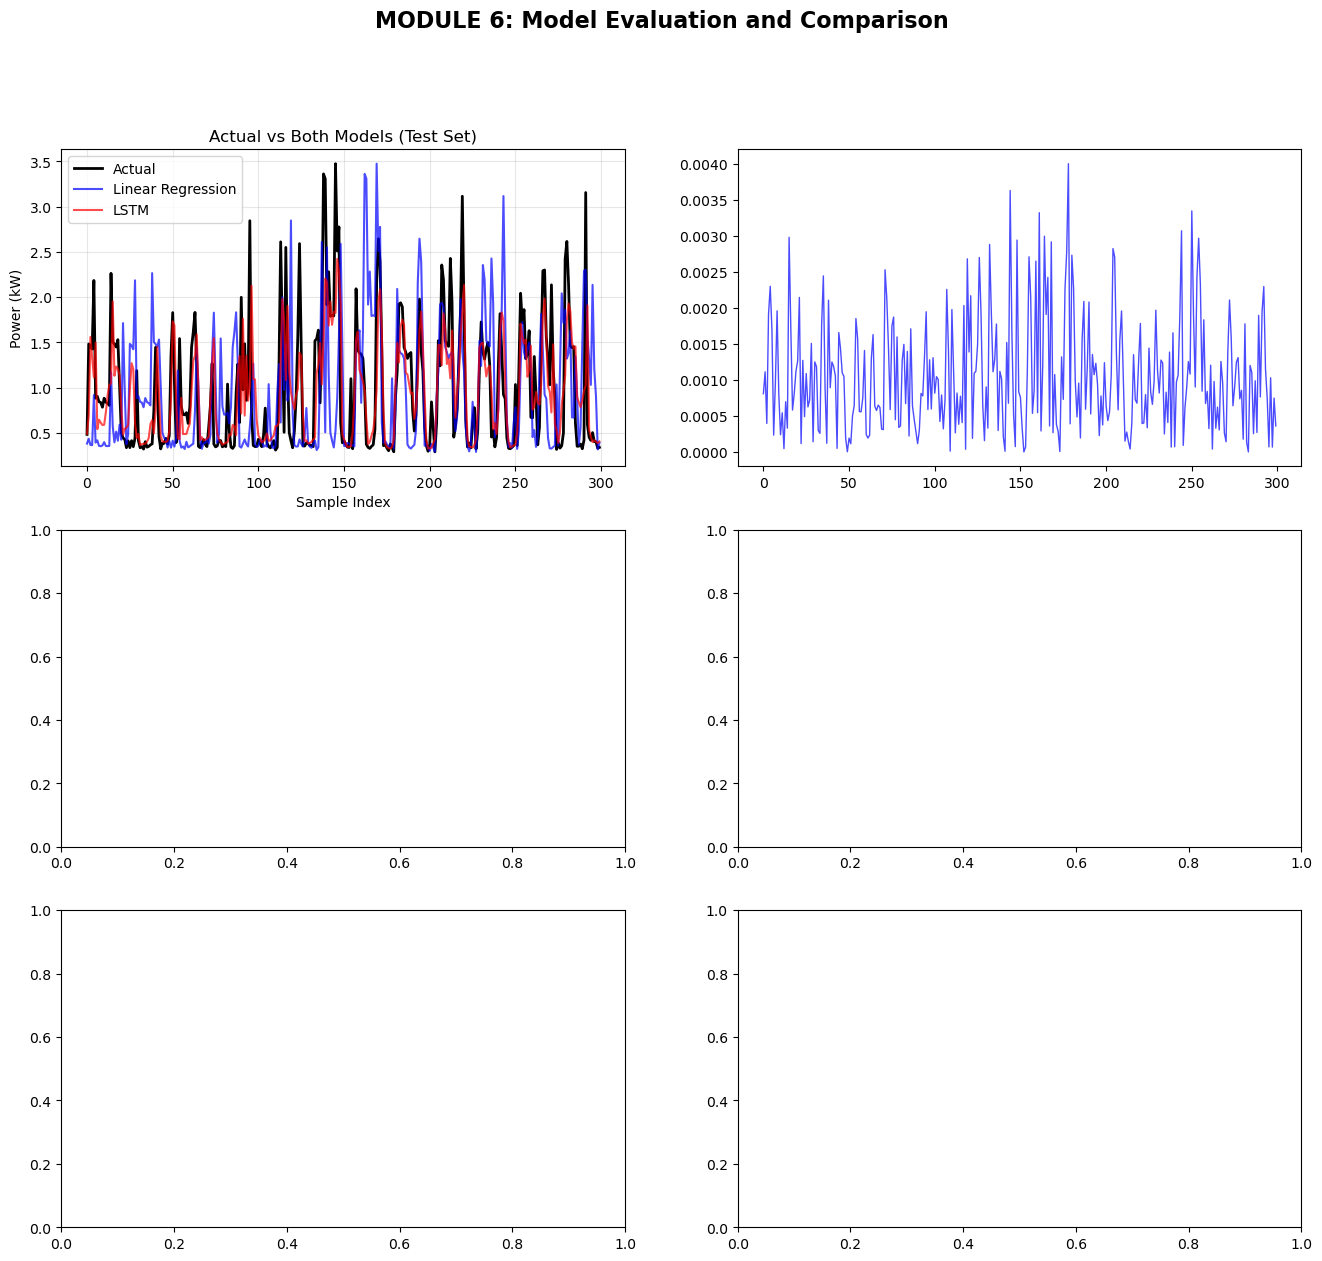

In [9]:
# Creating Evaluation Visualizations

fig, axes = plt.subplots(3, 2, figsize=(16, 14))
fig.suptitle('MODULE 6: Model Evaluation and Comparison', fontsize=16, fontweight='bold')

# Plot 1: Side-by-side Actual vs Predicted
ax1 = axes[0, 0]
sample = min(300, min_len)
ax1.plot(range(sample), lstm_preds['Actual'].iloc[:sample], 
        label='Actual', linewidth=2, color='black')
ax1.plot(range(sample), baseline_preds['Predicted'].iloc[:sample], 
        label='Linear Regression', linewidth=1.5, alpha=0.7, color='blue')
ax1.plot(range(sample), lstm_preds['Predicted'].iloc[:sample], 
        label='LSTM', linewidth=1.5, alpha=0.7, color='red')
ax1.set_title('Actual vs Both Models (Test Set)')
ax1.set_xlabel('Sample Index')
ax1.set_ylabel('Power (kW)')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 2: Error Comparison
ax2 = axes[0, 1]
ax2.plot(range(sample), baseline_preds['Absolute_Error'].iloc[:sample], 
        label='Linear Regression Error', linewidth=1, alpha=0.7, color='blue')
ax2.plot(range(sample), lstm_preds['Absolute_Error'].iloc[:sample], 
        label='LSTM Error', linewidth=1, alpha=0.7, color='red')
ax2.axhline(y=baseline_test['MAE'], color='blue', linestyle='--', 
        linewidth=1.5, label=f'LR MAE: {baseline_test["MAE"]:.3f}')
ax2.axhline(y=lstm_test['MAE'], color='red', linestyle='--', 
        linewidth=1.5, label=f'LSTM MAE: {lstm_test["MAE"]:.3f}')
ax2.set_title('Absolute Error Comparison')
ax2.set_xlabel('Sample Index')
ax2.set_ylabel('Absolute Error (kW)')
ax2.legend(fontsize=8)
ax2.grid(alpha=0.3)

# Plot 3: Scatter Plot Comparison
ax3 = axes[1, 0]
ax3.scatter(baseline_preds['Actual'], baseline_preds['Predicted'], 
        alpha=0.3, s=10, color='blue', label='Linear Regression')
ax3.scatter(lstm_preds['Actual'], lstm_preds['Predicted'], 
        alpha=0.3, s=10, color='red', label='LSTM')
min_val = baseline_preds['Actual'].min()
max_val = baseline_preds['Actual'].max()
ax3.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, label='Perfect')
ax3.set_title('Scatter: Both Models vs Perfect Prediction')
ax3.set_xlabel('Actual Power (kW)')
ax3.set_ylabel('Predicted Power (kW)')
ax3.legend()
ax3.grid(alpha=0.3)

# Plot 4: Metrics Bar Chart (Test Set)
ax4 = axes[1, 1]
metrics_names = ['MAE', 'RMSE']
x = np.arange(len(metrics_names))
width = 0.35

lr_vals = [baseline_test['MAE'], baseline_test['RMSE']]
lstm_vals = [lstm_test['MAE'], lstm_test['RMSE']]

bars1 = ax4.bar(x - width/2, lr_vals, width, label='Linear Regression', color='#3498DB')
bars2 = ax4.bar(x + width/2, lstm_vals, width, label='LSTM', color='#E74C3C')

ax4.set_title('MAE & RMSE Comparison (Test Set)')
ax4.set_xticks(x)
ax4.set_xticklabels(metrics_names)
ax4.set_ylabel('Error Value (kW)')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
     for bar in bars:
        h = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., h,
                f'{h:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 5: R² Score Comparison
ax5 = axes[2, 0]
models = ['Linear Regression', 'LSTM']
r2_scores = [baseline_test['R² Score'], lstm_test['R² Score']]
colors = ['#3498DB', '#E74C3C']
bars = ax5.bar(models, r2_scores, color=colors, edgecolor='black', width=0.5)
ax5.set_title('R² Score Comparison (Test Set)')
ax5.set_ylabel('R² Score')
ax5.set_ylim(0, 1.0)
ax5.axhline(y=0.9, color='green', linestyle='--', linewidth=1.5, label='90% threshold')
ax5.legend()
ax5.grid(axis='y', alpha=0.3)

for bar, score in zip(bars, r2_scores):
    ax5.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
        f'{score:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Plot 6: Error Distribution (Histogram)
ax6 = axes[2, 1]
ax6.hist(baseline_preds['Error'], bins=50, alpha=0.6, color='blue', 
        label='Linear Regression', edgecolor='black', linewidth=0.5)
ax6.hist(lstm_preds['Error'], bins=50, alpha=0.6, color='red', 
        label='LSTM', edgecolor='black', linewidth=0.5)
ax6.axvline(x=0, color='black', linestyle='-', linewidth=2)
ax6.set_title('Error Distribution Comparison')
ax6.set_xlabel('Error (Actual - Predicted) kW')
ax6.set_ylabel('Frequency')
ax6.legend()
ax6.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('module6_model_comparison.png', dpi=300, bbox_inches='tight')
print(" Visualization saved as 'module6_model_comparison.png'")
plt.show()

In [ ]:
# Creating Flask-Compatible Prediction Function


# Create prediction module (flask_prediction.py)
flask_prediction_code = '''"""
Flask-Compatible Prediction Module
Smart Energy Consumption Analysis
Supports both LSTM and Linear Regression models
"""

import numpy as np
import pandas as pd
import joblib
import tensorflow as tf
import json


# CONFIGURATION

BEST_MODEL = "{best_model}"  # Auto-set based on evaluation
SEQ_LENGTH = 24              # LSTM sequence length (24 hours)

# Feature list used by LSTM
LSTM_FEATURES = {features}


# MODEL LOADING FUNCTIONS

def load_lstm_model():
    """Load LSTM model and scalers"""
    model = tf.keras.models.load_model('lstm_energy_prediction_model.h5')
    scaler_X = joblib.load('lstm_feature_scaler.pkl')
    scaler_y = joblib.load('lstm_target_scaler.pkl')
    return model, scaler_X, scaler_y


def load_baseline_model():
    """Load baseline Linear Regression model and scaler"""
    model = joblib.load('baseline_linear_regression_model.pkl')
    scaler = joblib.load('baseline_feature_scaler.pkl')
    return model, scaler


# PREDICTION FUNCTIONS

def predict_lstm(input_data):
    """
    Predict energy consumption using LSTM model.
    
    Parameters:
        input_data: DataFrame with last 24 hours of data
                    Must contain all LSTM_FEATURES columns
    
    Returns:
        prediction: Predicted power in kW (float)
        confidence: Estimated confidence range (dict)
    """
    model, scaler_X, scaler_y = load_lstm_model()
    
    # Validate input
    missing = [f for f in LSTM_FEATURES if f not in input_data.columns]
    if missing:
        return None, {{"error": f"Missing features: {{missing}}"}}
    
    # Prepare input (last 24 hours, selected features)
    X = input_data[LSTM_FEATURES].values[-SEQ_LENGTH:]
    
    # Scale
    X_scaled = scaler_X.transform(X)
    
    # Reshape for LSTM: (1, seq_length, features)
    X_reshaped = X_scaled.reshape(1, SEQ_LENGTH, -1)
    
    # Predict
    pred_scaled = model.predict(X_reshaped, verbose=0).ravel()[0]
    
    # Inverse transform
    prediction = scaler_y.inverse_transform([[pred_scaled]])[0][0]
    
    # Confidence range (±10% of prediction)
    confidence = {{
        "lower": round(float(prediction * 0.9), 4),
        "upper": round(float(prediction * 1.1), 4),
        "prediction": round(float(prediction), 4)
    }}
    
    return round(float(prediction), 4), confidence


def predict_baseline(input_data):
    """
    Predict energy consumption using Linear Regression baseline.
    
    Parameters:
        input_data: DataFrame with feature columns
    
    Returns:
        prediction: Predicted power in kW (float)
        confidence: Estimated confidence range (dict)
    """
    model, scaler = load_baseline_model()
    
    # Use last row of input
    X = input_data.iloc[[-1]]
    
    # Scale
    X_scaled = scaler.transform(X)
    
    # Predict
    prediction = model.predict(X_scaled)[0]
    
    # Confidence range
    confidence = {{
        "lower": round(float(prediction * 0.9), 4),
        "upper": round(float(prediction * 1.1), 4),
        "prediction": round(float(prediction), 4)
    }}
    
    return round(float(prediction), 4), confidence


def predict(input_data, model_type=None):
    """
    Main prediction function - uses best model by default.
    
    Parameters:
        input_data: DataFrame with required features
        model_type: "lstm" or "baseline" (default: best model)
    
    Returns:
        result: dict with prediction, confidence, model_used
    """
    if model_type is None:
        model_type = "lstm" if BEST_MODEL == "LSTM" else "baseline"
    
    if model_type == "lstm":
        prediction, confidence = predict_lstm(input_data)
        model_used = "LSTM"
    else:
        prediction, confidence = predict_baseline(input_data)
        model_used = "Linear Regression"
    
    return {{
        "prediction": prediction,
        "confidence": confidence,
        "model_used": model_used,
        "unit": "kW"
    }}
'''.format(
    best_model=best_model_name,
    features=json.dumps(
        [f for f in pd.Series(open('lstm_selected_features.txt').read().strip().split('\\n')).tolist()]
        if __import__('os').path.exists('lstm_selected_features.txt') else []
    )
)

# Save the prediction module
with open('flask_prediction.py', 'w') as f:
    f.write(flask_prediction_code)

print(" Saved: flask_prediction.py")
print("   This module contains:")
print("   • load_lstm_model() - Loads LSTM model + scalers")
print("   • load_baseline_model() - Loads Linear Regression model")
print("   • predict_lstm() - LSTM prediction function")
print("   • predict_baseline() - Baseline prediction function")
print("   • predict() - Main function (auto-selects best model)")


In [ ]:
# Testing Predictions with Sample Inputs


# Load feature engineered data for sample inputs
df = pd.read_csv('C:/Users/battu/Documents/SmartEnergyML/data/processed/data_features_engineered.csv', index_col='Datetime', parse_dates=True)

# Load features list
features_list = open('C:/Users/battu/Documents/SmartEnergyML/data/processed/lstm_selected_features.txt').read().strip().split('\n')
features_list = [f.strip() for f in features_list if f.strip()]

# Test Case 1: Normal usage hour (weekday afternoon)
print("\n TEST CASE 1: Weekday Afternoon Sample")

# Pick a sample from the middle of dataset
sample_idx = len(df) // 2
sample_input = df.iloc[sample_idx - 24:sample_idx + 1].copy()
actual_value = df.iloc[sample_idx]['Global_active_power']

print(f"   Sample time: {df.index[sample_idx]}")
print(f"   Actual power: {actual_value:.4f} kW")

# Test LSTM prediction
try:
    model_lstm = tf.keras.models.load_model('C:/Users/battu/Documents/SmartEnergyML/data/processed/lstm_energy_prediction_model.h5')
    scaler_X = joblib.load('C:/Users/battu/Documents/SmartEnergyML/data/processed/lstm_feature_scaler.pkl')
    scaler_y = joblib.load('C:/Users/battu/Documents/SmartEnergyML/data/processed/lstm_target_scaler.pkl')
    
    X_sample = sample_input[features_list].values[-24:]
    X_scaled = scaler_X.transform(X_sample)
    X_reshaped = X_scaled.reshape(1, 24, -1)
    pred_scaled = model_lstm.predict(X_reshaped, verbose=0).ravel()[0]
    lstm_prediction = scaler_y.inverse_transform([[pred_scaled]])[0][0]
    lstm_error = abs(actual_value - lstm_prediction)
    
    print(f"   LSTM prediction: {lstm_prediction:.4f} kW")
    print(f"   LSTM error:      {lstm_error:.4f} kW")
except Exception as e:
    print(f"    LSTM test error: {e}")
    lstm_prediction = None

# Test Baseline prediction
try:
    model_lr = joblib.load('C:/Users/battu/Documents/SmartEnergyML/data/processed/baseline_linear_regression_model.pkl')
    scaler_lr = joblib.load('C:/Users/battu/Documents/SmartEnergyML/data/processed/baseline_feature_scaler.pkl')
    
    # Get all feature columns (exclude target and raw device cols)
    exclude = ['Global_active_power', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
    lr_features = [c for c in df.columns if c not in exclude]
    
    X_lr = sample_input[lr_features].iloc[[-1]]
    X_lr_scaled = scaler_lr.transform(X_lr)
    lr_prediction = model_lr.predict(X_lr_scaled)[0]
    lr_error = abs(actual_value - lr_prediction)
    
    print(f"   LR prediction:   {lr_prediction:.4f} kW")
    print(f"   LR error:        {lr_error:.4f} kW")
except Exception as e:
    print(f"    LR test error: {e}")
    lr_prediction = None

# Test Case 2: Different time period
print("\n TEST CASE 2: Different Time Period Sample")

sample_idx2 = len(df) * 3 // 4
sample_input2 = df.iloc[sample_idx2 - 24:sample_idx2 + 1].copy()
actual_value2 = df.iloc[sample_idx2]['Global_active_power']

print(f"   Sample time: {df.index[sample_idx2]}")
print(f"   Actual power: {actual_value2:.4f} kW")

try:
    X_sample2 = sample_input2[features_list].values[-24:]
    X_scaled2 = scaler_X.transform(X_sample2)
    X_reshaped2 = X_scaled2.reshape(1, 24, -1)
    pred_scaled2 = model_lstm.predict(X_reshaped2, verbose=0).ravel()[0]
    lstm_prediction2 = scaler_y.inverse_transform([[pred_scaled2]])[0][0]
    
    print(f"   LSTM prediction: {lstm_prediction2:.4f} kW")
    print(f"   LSTM error:      {abs(actual_value2 - lstm_prediction2):.4f} kW")
except Exception as e:
    print(f"    Test error: {e}")

# Test Case 3: Peak usage period
print("\n TEST CASE 3: Peak Usage Period Sample")

# Find a peak usage hour
peak_idx = df['Global_active_power'].idxmax()
peak_pos = df.index.get_loc(peak_idx)
if peak_pos > 24:
    sample_input3 = df.iloc[peak_pos - 24:peak_pos + 1].copy()
    actual_value3 = df.iloc[peak_pos]['Global_active_power']
    
    print(f"   Sample time: {peak_idx}")
    print(f"   Actual power (PEAK): {actual_value3:.4f} kW")
    
    try:
        X_sample3 = sample_input3[features_list].values[-24:]
        X_scaled3 = scaler_X.transform(X_sample3)
        X_reshaped3 = X_scaled3.reshape(1, 24, -1)
        pred_scaled3 = model_lstm.predict(X_reshaped3, verbose=0).ravel()[0]
        lstm_prediction3 = scaler_y.inverse_transform([[pred_scaled3]])[0][0]
        
        print(f"   LSTM prediction: {lstm_prediction3:.4f} kW")
        print(f"   LSTM error:      {abs(actual_value3 - lstm_prediction3):.4f} kW")
    except Exception as e:
        print(f"    Test error: {e}")

In [ ]:
# Saving Final Comparison Results


# Final comparison summary
final_summary = {
    'best_model': best_model_name,
    'baseline_metrics': baseline_test.to_dict(),
    'lstm_metrics': lstm_test.to_dict(),
    'lstm_wins': lstm_wins,
    'lr_wins': lr_wins
}

with open('model_comparison_summary.json', 'w') as f:
    json.dump(final_summary, f, indent=4)
print(" Saved: model_comparison_summary.json")

print(" Saved: module6_model_comparison.png")